In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install numpy scikit-learn
!pip install -q torch_geometric
!pip install -q class_resolver
!pip3 install pymatting
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.6 MB/s eta 0:00:00


In [11]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss
import torch
import torch.nn as nn
import torch.nn.functional as nnFn
import torch.optim as optim
import numpy as np
import random
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import TensorDataset, DataLoader, Subset
from torch_geometric.data import Data

In [12]:
data = np.load('/home/snu/Downloads/breastmnist_224.npz', allow_pickle=True)
all_images = np.concatenate([data['train_images'], data['val_images'], data['test_images']], axis=0)
all_labels = np.concatenate([data['train_labels'], data['val_labels'], data['test_labels']], axis=0).squeeze()

# Convert to 3-channel RGB
images = all_images.astype(np.float32) / 255.0
images = np.repeat(images[:, None, :, :], 3, axis=1)  # (N, 3, 224, 224)
X_torch = torch.tensor(images)
y_torch = torch.tensor(all_labels).long()

print(f"Raw images: {X_torch.shape}, Labels: {y_torch.shape}")

Raw images: torch.Size([780, 3, 224, 224]), Labels: torch.Size([780])


In [13]:
class0_idx = [i for i in range(len(y_torch)) if y_torch[i] == 0]
class1_idx = [i for i in range(len(y_torch)) if y_torch[i] == 1]

random.seed(42)
sampled_class0 = random.sample(class0_idx, min(1000, len(class0_idx)))
sampled_class1 = random.sample(class1_idx, min(1000, len(class1_idx)))

selected_indices = sampled_class0 + sampled_class1
random.shuffle(selected_indices)

subset_dataset = Subset(TensorDataset(X_torch, y_torch), selected_indices)
subset_loader = DataLoader(subset_dataset, batch_size=32, shuffle=False)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vit = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16')
vit.eval().to(device)

vit_feats, y_list = [], []

with torch.no_grad():
    for imgs, lbls in subset_loader:
        imgs = imgs.to(device)
        feats = vit(imgs)
        vit_feats.append(feats.cpu())
        y_list.extend(lbls.cpu().tolist())

F = torch.cat(vit_feats, dim=0).numpy().astype(np.float32)
y = np.array(y_list).astype(np.int64)

num_nodes, num_feats = F.shape
print(f"Extracted ViT-DINO Features: {F.shape}, Labels: {y.shape}")

Using cache found in /home/snu/.cache/torch/hub/facebookresearch_dino_main


Extracted ViT-DINO Features: (780, 768), Labels: (780,)


In [15]:
scaler = StandardScaler()
X = scaler.fit_transform(F)

In [16]:
# 20 stratified splits (10% train, 90% test per fold)
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=42)

In [17]:
# Metric storage
accuracies, precisions, recalls, f1_scores, losses = [], [], [], [], []

In [18]:
all_y_true = []
all_y_proba = []
all_fpr = []
all_tpr = []
all_auc = []
# Loop over folds
for fold, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    print(f"\nTraining fold {fold + 1}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    rf = RandomForestClassifier(n_estimators=200, max_depth=50, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    y_pred_proba = rf.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    loss = log_loss(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    losses.append(loss)
    all_y_true.extend(y_test)
    all_y_proba.extend(y_pred_proba)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(auc_score)

    print(f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Loss: {loss:.4f} | AUC: {auc_score:.4f}")

# Final average results
print("\nAverage Results across 20 folds:")
print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Cross-Entropy Loss: {np.mean(losses):.4f} ± {np.std(losses):.4f}")
print(f"Average AUC: {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")


Training fold 1
Accuracy: 0.8020 | Precision: 0.7997 | Recall: 0.9727 | F1: 0.8777 | Loss: 0.4675 | AUC: 0.7974

Training fold 2
Accuracy: 0.8248 | Precision: 0.8105 | Recall: 0.9922 | F1: 0.8922 | Loss: 0.4315 | AUC: 0.8596

Training fold 3
Accuracy: 0.7991 | Precision: 0.7915 | Recall: 0.9844 | F1: 0.8775 | Loss: 0.4684 | AUC: 0.8413

Training fold 4
Accuracy: 0.7749 | Precision: 0.7661 | Recall: 0.9961 | F1: 0.8661 | Loss: 0.4808 | AUC: 0.8153

Training fold 5
Accuracy: 0.7934 | Precision: 0.7840 | Recall: 0.9903 | F1: 0.8751 | Loss: 0.4699 | AUC: 0.8054

Training fold 6
Accuracy: 0.8177 | Precision: 0.8070 | Recall: 0.9864 | F1: 0.8877 | Loss: 0.4606 | AUC: 0.8345

Training fold 7
Accuracy: 0.7977 | Precision: 0.7968 | Recall: 0.9708 | F1: 0.8752 | Loss: 0.4787 | AUC: 0.8154

Training fold 8
Accuracy: 0.8077 | Precision: 0.7962 | Recall: 0.9903 | F1: 0.8827 | Loss: 0.4462 | AUC: 0.8877

Training fold 9
Accuracy: 0.7764 | Precision: 0.7697 | Recall: 0.9903 | F1: 0.8662 | Loss: 0.46

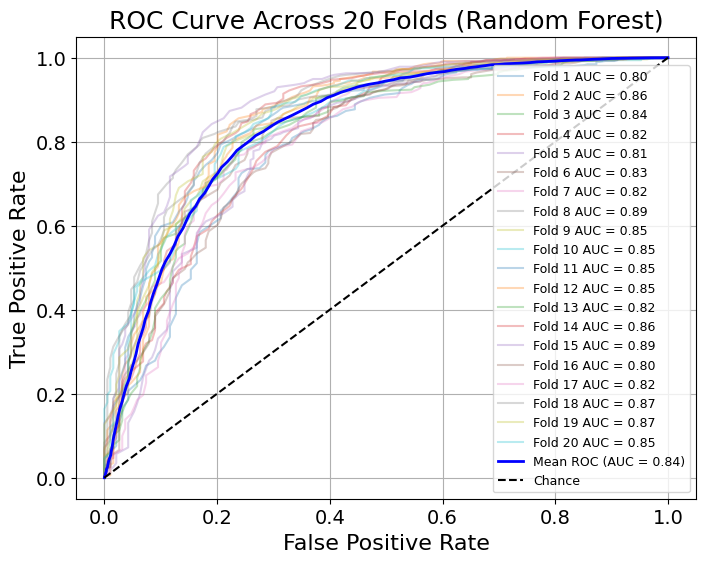

In [19]:
plt.figure(figsize=(8, 6))

for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], alpha=0.3, label=f"Fold {i+1} AUC = {all_auc[i]:.2f}")

# Average ROC Curve
fpr_avg, tpr_avg, _ = roc_curve(all_y_true, all_y_proba)
auc_avg = roc_auc_score(all_y_true, all_y_proba)
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2, label=f"Mean ROC (AUC = {auc_avg:.2f})")

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("ROC Curve Across 20 Folds (Random Forest)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)